In [ ]:
#| hide
from ready_steady_go.benchmark import *

# Ready, Steady, Go!


## How it works
The benchmark runs the standard PyTorch training loop on a (image classifier) model of your choice with specified batch size and FP16/FP32. The result is the measure of throughput - numed of trainig samples per second. It can be sent to [Wights & Biases](https://wandb.ai/xl0/ready-steady-go).

> Note: The data never leaves the GPU, and the throughput should be mostly independent of the rest of the system, at least for larger batch sizes.


## Install


#### From `pip`

```sh
pip install ready-steady-go
```


# My Results

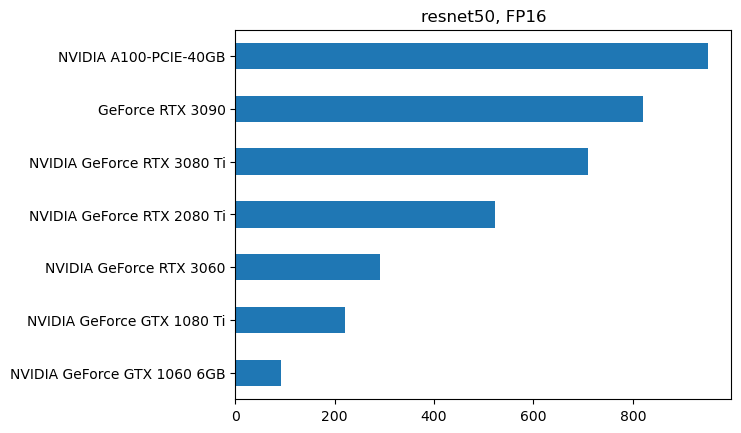

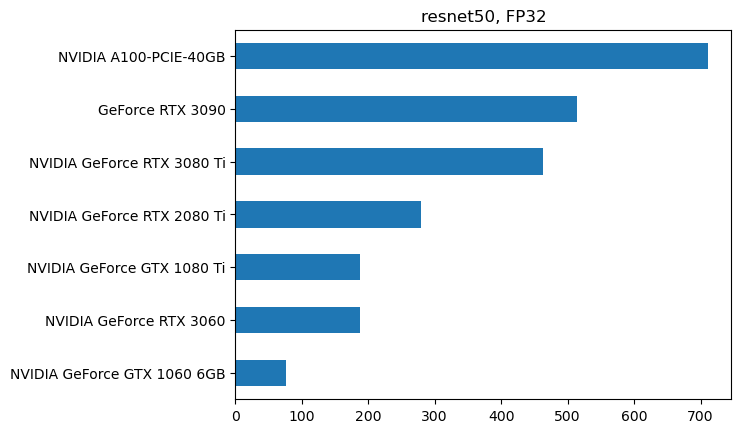

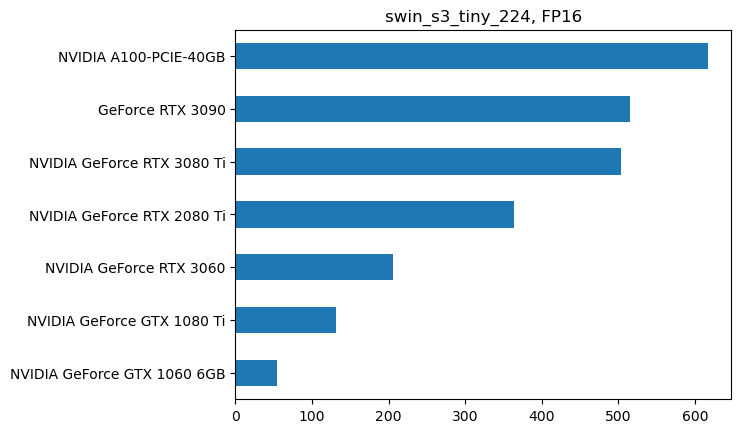

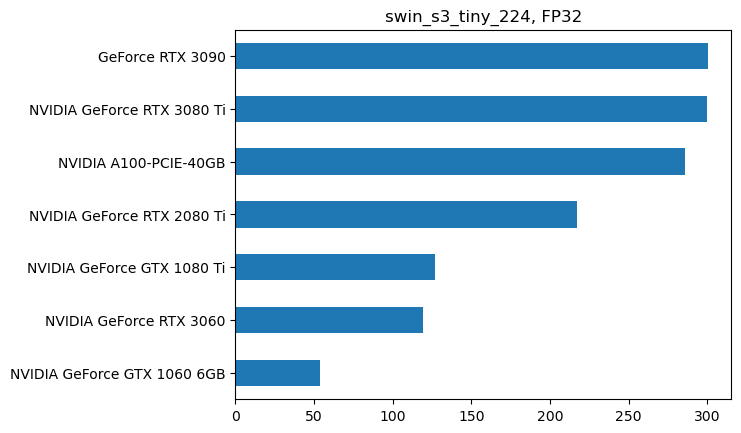

In [ ]:

#| code-fold: true
#| code-summary: "Show the code"

import wandb
import pandas as pd
from matplotlib import pyplot as plt

api = wandb.Api()

runs = api.runs("xl0/gpu-sprint")
summaries = [ dict(r.summary) | {"id": r.id} for r in runs if r.state == "finished"]

df = pd.DataFrame.from_records(summaries)

df = df[["device_name", "model", "bs", "fp16", "throughput"]]
df["fp16"] = df["fp16"].apply(lambda x: "FP16" if x else "FP32")
df.dropna(inplace=True)

for model in df.model.unique():
    for fp in df.fp16.unique():

        

        data = df.loc[ df.model.eq(model) & df.fp16.eq(fp) ]
        sorted_best_bs = data.groupby("device_name")["throughput"].max().sort_values()
    
        ax = sorted_best_bs.plot.barh(title=f"{model}, {fp}")
        ax.set_ylabel(None)
        plt.show(ax)
